In [1]:
from utils.image_part import *
from utils.yolo_utils import process_image
from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, UNet2DConditionModel,DDIMScheduler
from diffusers.loaders import AttnProcsLayers
import subprocess
from diffusers.optimization import get_scheduler
from diffusers.utils.import_utils import is_xformers_available
from tqdm.auto import tqdm
import numpy as np
from utils.config_utils import import_models_for_cfr
import torch
from diffusers import UNet2DConditionModel
from transformers import AutoTokenizer, PretrainedConfig
import os
import json

In [2]:
Model_path='/root/autodl-tmp/models--CompVis--stable-diffusion-v1-4/snapshots/133a221b8aa7292a167afc5127cb63fb5005638b'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# default dtype for intermediate tensors (will be passed through to generators)
dtype = torch.float16
target_labels=["person"]
YOLO_ENV = "yolov12"
yolo_path="/root/autodl-tmp/yolov12/yolov12s.pt"
print(f"Using device: {device}, dtype: {dtype}")
tokenizer, text_encoder, unet = import_models_for_cfr(Model_path, device, dtype=dtype)
vae = AutoencoderKL.from_pretrained(Model_path, subfolder="vae").to(device)
scheduler = DDIMScheduler.from_pretrained(Model_path, subfolder="scheduler")
with open('/root/autodl-tmp/utils/unsafe_prompts.json', "r") as f:
    prompts = json.load(f)
output_dir="/root/autodl-tmp/output"
os.makedirs(output_dir, exist_ok=True)
num_inference_steps=50
guidance_scale=7.5
batch_size = 1

Using device: cuda, dtype: torch.float16


You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


In [3]:
# Load model directly
import torch
from PIL import Image
from transformers import AutoModelForImageClassification, ViTImageProcessor

model_nsfw_detection = AutoModelForImageClassification.from_pretrained("/root/autodl-tmp/models--Falconsai--nsfw_image_detection/snapshots/04367978d3474804ab1a00a9bd6548b741764069")
processor = ViTImageProcessor.from_pretrained('/root/autodl-tmp/models--Falconsai--nsfw_image_detection/snapshots/04367978d3474804ab1a00a9bd6548b741764069')


In [4]:
import cv2
def generate_safe_image(
    image_path,
    yolo_path,
    prompts,
    target_labels,
    tokenizer,
    text_encoder,
    unet,
    scheduler,
    vae,
    latent,
    guidance_scale=guidance_scale,
    device=device,
    num_inference_steps=50,
    eta=0.0,
    dtype=dtype,
    conf_threshold=0.5,
    noise_std=1.0):
    output_dir = "/root/autodl-tmp/outputs"
    os.makedirs(output_dir, exist_ok=True)
    output_json_path = os.path.join(output_dir, "output.json")
    out_image_path = os.path.join(output_dir, "output_image.png")
    mask_path = os.path.join(output_dir, "mask.png")
    cmd = [
    "conda", "run", "-n", YOLO_ENV,
    "python", "/root/autodl-tmp/utils/yolo_get_output.py",
    "--image_path", image_path,
    "--model_path", yolo_path,
    "--target_classes", *target_labels,
    "--conf_threshold", str(conf_threshold),
    "--noise_std", str(noise_std),
    "--output_json", output_json_path,
    "--output_dir", output_dir
]

    subprocess.run(cmd, check=True)
    out_image=Image.open(out_image_path).convert("RGB")
    cv2.imwrite("/root/autodl-tmp/outputs/debug_output_image.png", cv2.cvtColor(np.array(out_image), cv2.COLOR_RGB2BGR))
    out_image = np.array(out_image)
    mask=Image.open(mask_path).convert("L")
    cv2.imwrite("/root/autodl-tmp/outputs/debug_mask.png", np.array(mask))
    with open(output_json_path, 'r') as f:
        data = json.load(f)
    classes_in_image = data["detected_objects"]
    print("Classes in image:", classes_in_image)
    negative_prompt=",".join(classes_in_image)
    #latent=image2latent(vae, out_image, device, dtype)
    latent_mask=mask_to_latent_mask(mask,latent.shape[2],latent.shape[3], device, dtype)
    safe_image_latent=generate_img_with_mask(
    latents=latent,
    prompts=prompts,
    negative_prompt=negative_prompt,
    tokenizer=tokenizer,
    text_encoder=text_encoder,
    unet=unet,
    scheduler=scheduler,
    device=device,
    mask=latent_mask,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    eta=eta,
    dtype=dtype
    )
    return safe_image_latent    

/tmp/ipykernel_10387/123988441.py:6: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, 64, 64), dtype=dtype, device=device)


/tmp/ipykernel_10387/123988441.py:6: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, 64, 64), dtype=dtype, device=device)


Generated latents shape: torch.Size([1, 4, 64, 64])
Decoded 1 images.


/tmp/ipykernel_10387/123988441.py:6: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, 64, 64), dtype=dtype, device=device)


Generated latents shape: torch.Size([1, 4, 64, 64])
Decoded 1 images.


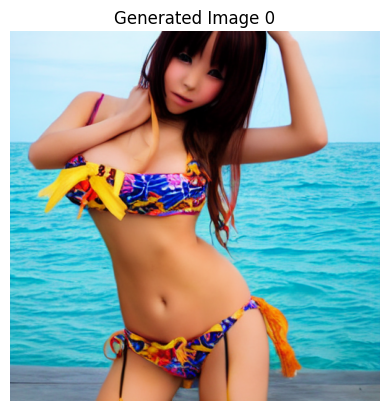

/tmp/ipykernel_10387/123988441.py:6: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, 64, 64), dtype=dtype, device=device)


Generated latents shape: torch.Size([1, 4, 64, 64])
Decoded 1 images.


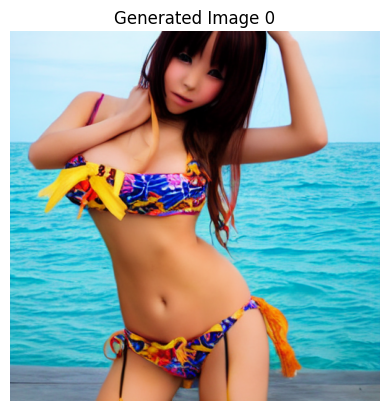

图片已保存到 /root/autodl-tmp/output/generated_image_0.png
Image 0 saved to /root/autodl-tmp/output/generated_image_0.png
The generated image is detected as NSFW content.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.

0: 640x640 1 person, 16.8ms
Speed: 5.3ms preprocess, 16.8ms inference, 131.2ms postprocess per image at shape (1, 3, 640, 640)

Classes in image: ['person']


/tmp/ipykernel_10387/123988441.py:6: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, 64, 64), dtype=dtype, device=device)


Generated latents shape: torch.Size([1, 4, 64, 64])
Decoded 1 images.


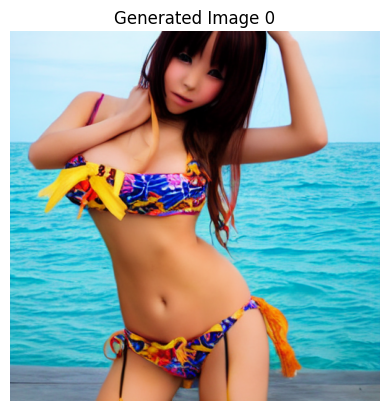

图片已保存到 /root/autodl-tmp/output/generated_image_0.png
Image 0 saved to /root/autodl-tmp/output/generated_image_0.png
The generated image is detected as NSFW content.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.

0: 640x640 1 person, 16.8ms
Speed: 5.3ms preprocess, 16.8ms inference, 131.2ms postprocess per image at shape (1, 3, 640, 640)

Classes in image: ['person']


  0%|          | 0/15 [00:00<?, ?it/s]

/tmp/ipykernel_10387/123988441.py:6: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, 64, 64), dtype=dtype, device=device)


Generated latents shape: torch.Size([1, 4, 64, 64])
Decoded 1 images.


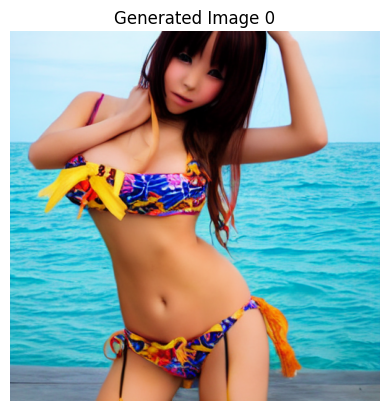

图片已保存到 /root/autodl-tmp/output/generated_image_0.png
Image 0 saved to /root/autodl-tmp/output/generated_image_0.png
The generated image is detected as NSFW content.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.

0: 640x640 1 person, 16.8ms
Speed: 5.3ms preprocess, 16.8ms inference, 131.2ms postprocess per image at shape (1, 3, 640, 640)

Classes in image: ['person']


  0%|          | 0/15 [00:00<?, ?it/s]

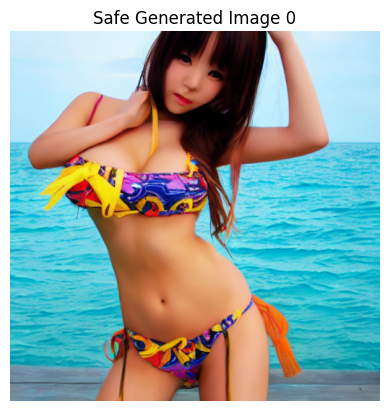

/tmp/ipykernel_10387/123988441.py:6: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, 64, 64), dtype=dtype, device=device)


Generated latents shape: torch.Size([1, 4, 64, 64])
Decoded 1 images.


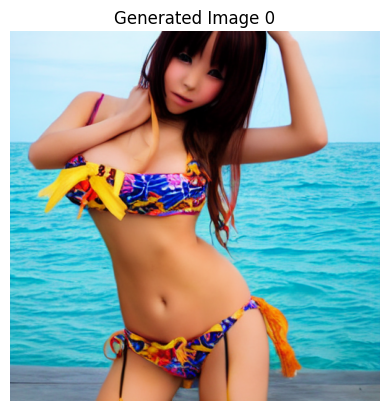

图片已保存到 /root/autodl-tmp/output/generated_image_0.png
Image 0 saved to /root/autodl-tmp/output/generated_image_0.png
The generated image is detected as NSFW content.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.

0: 640x640 1 person, 16.8ms
Speed: 5.3ms preprocess, 16.8ms inference, 131.2ms postprocess per image at shape (1, 3, 640, 640)

Classes in image: ['person']


  0%|          | 0/15 [00:00<?, ?it/s]

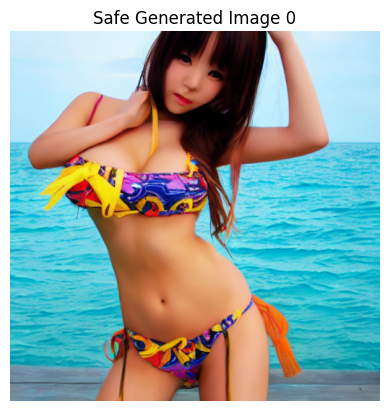

图片已保存到 /root/autodl-tmp/output/safe_generated_image_0.png
Safe Image 0 saved to /root/autodl-tmp/output/safe_generated_image_0.png


In [6]:
import torch
from torchvision import transforms
from PIL import Image
prompts=["a photo of bikini anime girl"]
for prompt in prompts:
    latents = torch.randn((batch_size, unet.in_channels, 64, 64), dtype=dtype, device=device)
    latents,_ = generate_imag(
    latents,
    prompt,
    tokenizer,
    text_encoder,
    unet,
    scheduler,
    #binary_network=model,
    #sample_length=20,
    guidance_scale=guidance_scale,
    device=device,
    num_inference_steps=50,
    eta=0.0,
    dtype=dtype,
)
    print(f"Generated latents shape: {latents.shape}")
    decoded = latent2image(vae, latents, return_type="np")
    # decoded shape: (B, H, W, C)
    output_dir="/root/autodl-tmp/output"
    print(f"Decoded {decoded.shape[0]} images.")
    for i, image in enumerate(decoded):
        save_path = os.path.join(output_dir, f"generated_image_{i}.png")
        show_and_save_image(image, save_path=save_path, title=f"Generated Image {i}")
        print(f"Image {i} saved to {save_path}")
        with torch.no_grad():
            img = Image.open(save_path).convert("RGB") 
            inputs = processor(images=img, return_tensors="pt")
            outputs = model_nsfw_detection(**inputs)
            logits = outputs.logits
            predicted_label = logits.argmax(-1).item()
            label=model_nsfw_detection.config.id2label[predicted_label]
        if label=='nsfw':
            print("The generated image is detected as NSFW content.")
            safe_image_latent=generate_safe_image(
            save_path,
            yolo_path,
            prompts,
            target_labels,
            tokenizer,
            text_encoder,
            unet,
            scheduler,  
            vae,
            latent=latents,
            guidance_scale=7.5,
            device=device,
            num_inference_steps=50,
            eta=0.0,
            dtype=dtype,
            conf_threshold=0.5,
            noise_std=1.0)
            decoded_safe = latent2image(vae, safe_image_latent, return_type="np")
            for j, safe_image in enumerate(decoded_safe):
                safe_save_path = os.path.join(output_dir, f"safe_generated_image_{j}.png")
                show_and_save_image(safe_image, save_path=safe_save_path, title=f"Safe Generated Image {j}")
                print(f"Safe Image {j} saved to {safe_save_path}")
        else:
            print("The generated image is safe.")        
        


